# Exploring the BPZ Test Data

_Alex Malz & Phil Marshall_

We have a small dataset to test our `qp` approximations on: 30,000 photometric redshift 1D posterior PDFs, in "gridded" format, from Melissa Graham (UW, LSST). In this notebook we visualize these distributions, and develop machinery to evaluate our approximations on the whole set in "survey mode." 

## Set-up, Ingest

In [1]:
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import qp

The data file doesn't appear to come with redshifts at which the PDFs are evaluated, but we are told they're evenly spaced between 0.1 and 3.51.

In [2]:
z = np.arange(0.01, 3.51, 0.01, dtype='float')
zrange = 3.51-0.01

The PDFs in the data file aren't properly normalized.  In order to be PDFs, we want $\int\ p(z)\ dz=1$, but the data file entries satisfy $\sum_{z}\ p(z)=1$, which is not the same.  We approximate the desired integral as $\int\ p(z)\ dz\ \approx\ \Delta z\ \sum_{i}^{N}\ p(z_{i})$ where $\Delta z=\frac{z_{max}-z_{min}}{N}$ is the distance between each neighbor pair $i$ of $N$ redshifts at which the PDF is evaluated.

In [3]:
with open('bpz_euclid_test_10_2.probs', 'rb') as data_file:
    lines = (line.split(None) for line in data_file)
    lines.next()
    # lines.next()
    pdfs = np.array([[float(line[k]) for k in range(1,len(line))] for line in lines])
    pdf_shape = np.shape(pdfs)
    #print(np.sum(pdfs, axis=1)[:100] / zrange)
    norm_factor = zrange / pdf_shape[1]
    pdfs /= norm_factor
    print(np.sum(pdfs * zrange, axis=1)[:100])
data_file.close()
log_pdfs = qp.utils.safelog(pdfs)
pdfs = np.exp(log_pdfs)
print(np.sum(pdfs, axis=1)[:100])

[ 350.0175    349.99643   350.001925  350.04025   349.9832    350.0266
  349.986     350.00623   350.004445  349.979     350.03535   349.99916
  349.99195   350.01505   349.99055   349.99986   349.998495  349.9951
  350.01365   349.99545   349.965     349.99951   349.96395   350.0077
  350.003885  349.96675   350.0154    349.9643    350.01218   349.9587
  349.99531   350.        350.01015   350.028     350.0364    349.99874
  349.99965   350.02625   350.0273    350.00119   349.97165   350.002065
  349.9664    350.002065  349.9993    350.0028    350.003115  349.99475
  350.0259    349.991005  350.028     350.00875   349.999545  349.99867
  350.03465   349.996675  350.00469   350.0308    350.01645   350.04515
  350.004235  349.992475  349.997025  349.997515  350.00945   350.00245
  350.003325  349.9811    349.98971   350.005215  350.        349.998215
  350.00315   349.9839    350.04865   350.0126    350.0014    350.006545
  349.993455  350.00693   350.003745  350.00175   350.05425   350

## Visualizing the BPZ $p(z)$'s

Let's plot a few interesting PDFs from the dataset.

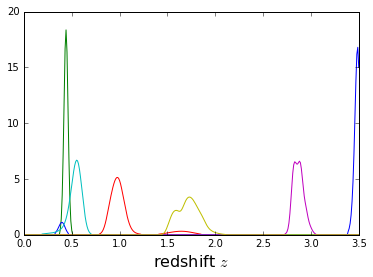

In [4]:
indices = [1, 3, 14, 16, 19, 21]
colors = 'rgbcmy'
for i in range(len(colors)):
    plt.plot(z, pdfs[indices[i]], color=colors[i])
plt.xlabel('redshift $z$', fontsize=16)

Now, let's turn one of them into a `qp.PDF` object initialized with a gridded parametrization.

Is your gridded input properly normalized? qp does not check normalization!
Plotted gridded.


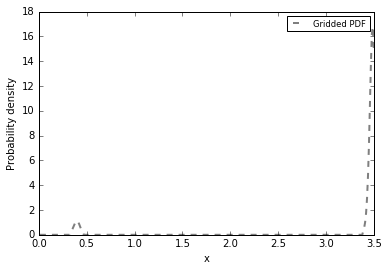

In [5]:
# chosen = random.choice(indices)
# print(chosen)

chosen=14
G = qp.PDF(gridded=(z, pdfs[chosen]))
G.plot()

## Approximating the BPZ $p(z)'s$


Quantile and histogram representations cannot be computed directly from gridded PDFs - we need to make a GMM first, and use this to instantiate a `qp.PDF` object using a `qp.composite` object based on that GMM as `qp.PDF.truth`.  Currently, a GMM can only be fit to samples, so we start by sampling our gridded parametrization.

Interpolating the `gridded` parametrization
Creating a `linear` interpolator for the gridded parametrization.
Plotted gridded.
Interpolating the `samples` parametrization
Creating a `linear` interpolator for the samples parametrization.
Plotted samples


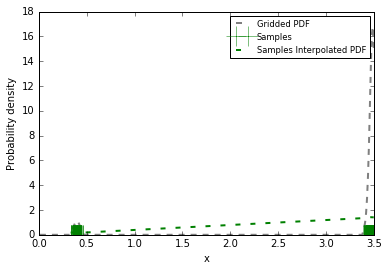

In [6]:
G.sample(1000, vb=False)
G.plot()

Now that there are samples, we can fit the GMM, producing a `qp.composite` object.

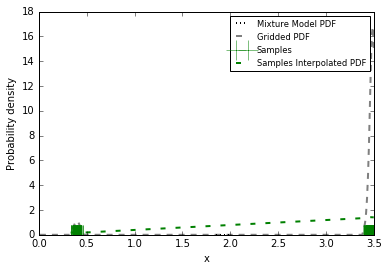

In [7]:
M_dist = G.mix_mod_fit(n_components=2, vb=False)
G.plot(vb=False)

The `qp.composite` object can be used as the `qp.PDF.truth` to initialize a new `qp.PDF` object that doesn't have any information about the gridded or sample approximations.  Now we can approximate it any way we like!

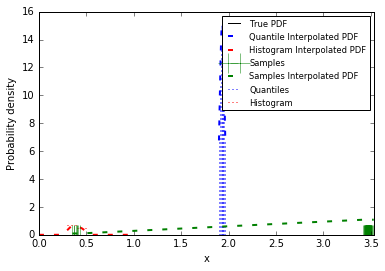

In [8]:
M = qp.PDF(truth=M_dist)
M.quantize(vb=False)
M.histogramize(vb=False)
M.sample(N=100,vb=False)
M.plot(vb=False)

## Quantifying the Accuracy of the Approximation

Let's compute the RMSE and KLD between each approximation and the truth.

In [9]:
def compare(M, vb=False):
    P = qp.PDF(truth=M.truth)
    Q = {}
    Q['quantiles'] = qp.PDF(quantiles=M.quantize(N=100, vb=vb), vb=vb)
    Q['histogram'] = qp.PDF(histogram=M.histogramize(N=100, vb=vb), vb=vb)
    Q['samples'] = qp.PDF(samples=M.sample(N=100, vb=vb), vb=vb)
    KLD = {}
    for approximation in Q.keys():
        KLD[approximation] = qp.utils.calculate_kl_divergence(P, Q[approximation], limits=[0.0, 1.0], vb=False)
    print KLD
    return

compare(M)

{'quantiles': 33.515029197896453, 'samples': 2.5188842897269996, 'histogram': 8.569421150259179e-05}
